In [31]:
import os
import shutil#
import numpy as np
import torch
import torch.optim as optim
import models
from argparse import Namespace
import torch.optim as optim
import utils
import my_utils
import pandas as pd
import importlib
import time
import vae_models
from glob import glob
import matplotlib.pyplot as plt
import sys
from dataset import DataSet
%matplotlib inline


%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<ErrorbarContainer object of 3 artists>

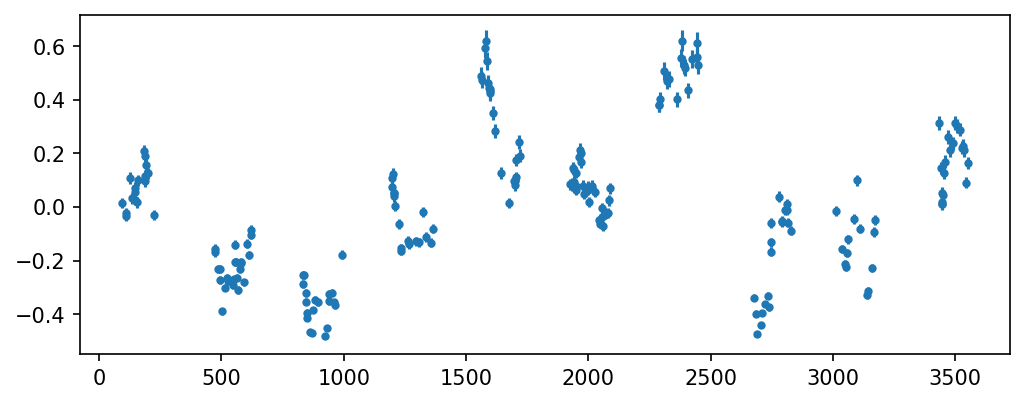

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from eztao.carma import DRW_term, DHO_term
from eztao.ts import gpSimRand

# define a DRW kernel & and simulate a process
amp, tau = np.log([0.2, 100])
DRW_kernel = DRW_term(amp, tau)
t, y, yerr = gpSimRand(DRW_kernel, 10, 365*10, 200)
fig, ax = plt.subplots(1,1, dpi=150, figsize=(8,3))
ax.errorbar(t, y, yerr, fmt='.')

<ErrorbarContainer object of 3 artists>

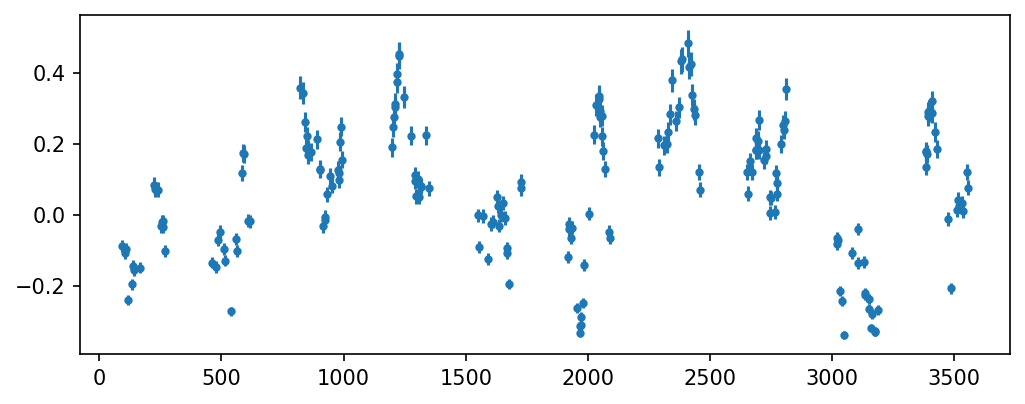

In [33]:
a1,a2,b1,b2 = np.log([1.0,1.0,1.0,1.0])
DHO_kernel = DHO_term(a1,a2,b1,b2)
t, y, yerr = gpSimRand(DRW_kernel, 10, 365*10, 200)
fig, ax = plt.subplots(1,1, dpi=150, figsize=(8,3))
ax.errorbar(t, y, yerr, fmt='.')

In [34]:
# TODO

# CREATE SYNTHETIC multivariate data, make hetvae compatible again
# last dim is time 
# middle dims are 



In [35]:
synth = np.array([gpSimRand(DRW_kernel, 10, 365*10, 200) for _ in range(100)]).transpose(0,2,1)

In [36]:
##### making synthetic data multivariate

length = synth.shape[1]
dims = 1
size = int(length / dims)
num_examples = synth.shape[0]
union_tps_all = []
data = np.zeros((num_examples, length, dims))
samples = []
max_union_tps = []
for i in range(num_examples):
    union_tps = []
    sample = []
    subset_lengths = np.random.randint(low=50, high=100, size=dims)
    # each dimension could be a random subset of the original, scaled, shifted,
    for j in range(dims):   
        obs_points = np.sort(np.random.choice(np.arange(length), size=subset_lengths[j], replace=False))
        sample_j = synth[i, obs_points, :]
        
        ##### here we could vary y vals, t vals for each dim
        #sample_j[:,0] += np.random.uniform(50,100)# shift by arbitrary amount!
        #sample_j[:,1] *= np.random.rand() # scale by arbitrary amount!
        
        union_tps.extend(sample_j[:, 0])
        t,y,yerr = sample_j[:,0], sample_j[:,1], sample_j[:,2]
        sample.append(sample_j)
        
    samples.append(sample)
    union_tps = list(set(union_tps))
    union_tps.sort() # save these 
    union_tps_all.append(union_tps)
    if len(union_tps) > len(max_union_tps):
        max_union_tps = union_tps
        
        
for i in range(num_examples):
    sample = samples[i]
    for j in range(dims):
        sample_j = sample[j]
        new_t = union_tps_all[i]
        new_y = np.zeros(len(new_t))
        new_yerr = np.zeros(len(new_t))
        # get relative indexes
        mask = np.isin(new_t, sample_j[:,0])
        indexes = np.where(mask)[0]
        # subsampled the mask! # maybe astromer one? -------------- 
        subsampled_mask = np.zeros_like(new_y)
        recon_mask = np.zeros_like(new_y)
        
        length = int((mask * 1).sum() * np.random.uniform(0.35, 0.65))
        obs_points = np.sort(np.random.choice(indexes, size=length, replace=False))
        subsampled_mask[obs_points] = 1
        recon_mask = np.logical_xor(subsampled_mask, recon_mask)
        #-----------------------------------------------------------
        
        new_y[indexes] = sample_j[:,1]
        new_yerr[indexes] = sample_j[:,2]

        need_to_append = len(max_union_tps) - len(new_t)
        sample_j = np.array([new_t, new_y, new_yerr, mask, subsampled_mask, recon_mask]).T
        sample_j = np.append(sample_j, np.zeros((need_to_append, 6)), axis=0)
        # mask subsampled masks?
        
        
        samples[i][j] = sample_j
  

samples = np.array(samples)


In [37]:
print(samples.shape) 
# first dim is number of examples
# second dim is multivariate dimension
# third is the length
# fourth is 4 dimensions, being t, y, yerr, mask, sub_mask, recon_mask


(100, 1, 99, 6)


<ErrorbarContainer object of 3 artists>

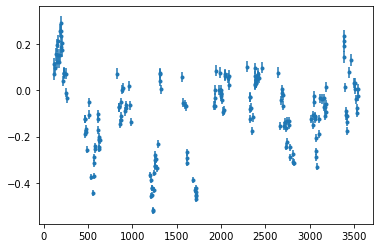

In [38]:

synth1 = synth[0]
plt.errorbar(synth1[:,0], synth1[:,1], synth1[:,2], fmt='.')

<ErrorbarContainer object of 3 artists>

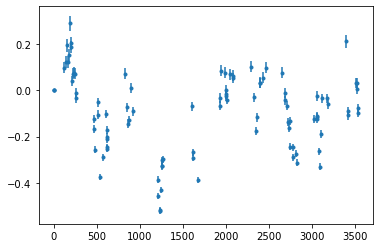

In [39]:
# confirming this is just a random subset of the original 
plt.errorbar(samples[0,0,:,0], samples[0,0,:,1], samples[0,0,:,2], fmt='.')

In [40]:
args = Namespace(batch_size=8, bound_variance=False, const_var=False,dropout=0.19462264721791603, 
                 elbo_weight=4.108914123847402, embed_time=32, enc_num_heads=4, intensity=True, k_iwae=1, kl_annealing=False, 
                 kl_zero=False, latent_dim=32, lr=0.001, mixing='concat_and_mix', mse_weight=4.060280688730988, net='hetvae', 
                 niters=1000, norm=True, normalize_input='znorm', num_ref_points=32, rec_hidden=32, recon_loss=False, 
                 sample_tp=0.4733820088130086, save=True, seed=0, shuffle=True, std=0.1, var_per_dim=False, width=512, device='mps')



In [41]:
DIM = 1
seed = args.seed
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device('mps' if torch.has_mps else 'cpu')

In [42]:
samples = samples.astype('float32')
training, valid = np.split(samples, [int(np.floor(1*len(samples)))])# shuffle?
train_loader = torch.utils.data.DataLoader(training, batch_size=args.batch_size)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=args.batch_size)
max_union_tps = torch.Tensor(max_union_tps)

In [43]:
net = models.load_network(args, DIM, max_union_tps)
#net = models.load_network(args, DIM, torch.Tensor(Edelson.union_x))  
params = list(net.parameters())
optimizer = optim.Adam(params, lr=0.003572758547163779)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=150)

In [44]:
for g in optimizer.param_groups:
    print(g['lr'])
    g['lr'] = 0.001463275753032352

0.003572758547163779


In [45]:
for itr in range(1, args.niters + 1):
      train_loss = 0
      train_n = 0
      avg_loglik, avg_kl, mse, mae = 0, 0, 0, 0
        
      for train_batch in train_loader:
          batch_len = train_batch.shape[0]
          train_batch = train_batch.to(device)
          
          subsampled_mask = train_batch[:,:,:,4]
          recon_mask = train_batch[:,:,:,5]
            
          context_y = torch.cat((
              train_batch[:,:,:,1] * subsampled_mask, subsampled_mask
          ), 1).transpose(2,1) # torch.Size([128, 203, 82]) # batch size, length, dims
           # torch.Size([128, 203])
          recon_context_y = torch.cat((
              train_batch[:,:,:,1] * recon_mask, recon_mask
          ), 1).transpose(2,1)
          loss_info = net.compute_unsupervised_loss(
              train_batch[:, 0, :,0],
              context_y,
              train_batch[:, 0, :,0],
              recon_context_y,
              num_samples=args.k_iwae,
              beta=1,
          )
          optimizer.zero_grad()
          loss_info.composite_loss.backward()
          optimizer.step()
          train_loss += loss_info.composite_loss.item() * batch_len
          avg_loglik += loss_info.loglik * batch_len
          avg_kl += loss_info.kl * batch_len
          mse += loss_info.mse * batch_len
          mae += loss_info.mae * batch_len
          train_n += batch_len
      print(itr)
      if itr % 10 == 0:
          print(
              'Iter: {}, train loss: {:.4f}, avg nll: {:.4f}, avg kl: {:.4f}, '
              'mse: {:.6f}, mae: {:.6f}'.format(
                  itr,
                  train_loss / train_n,
                  -avg_loglik / train_n,
                  avg_kl / train_n,
                  mse / train_n,
                  mae / train_n
              )
          )
#           for loader, num_samples in [(valid_loader, 5), (test_loader, 100)]:
#               utils.evaluate_hetvae(
#                   net,
#                   dim,
#                   loader,
#                   0.5,
#                   shuffle=False,
#                   k_iwae=num_samples,
#                   device=device
#               )

1
2
3
4
5
6
7
8
9
10
Iter: 10, train loss: -0.6523, avg nll: -0.2130, avg kl: 0.0167, mse: 0.037997, mae: 0.154135
11
12
13
14
15
16
17
18
19
20
Iter: 20, train loss: -0.6867, avg nll: -0.2173, avg kl: 0.0127, mse: 0.037934, mae: 0.153947
21
22
23
24
25
26
27
28
29
30
Iter: 30, train loss: -0.6458, avg nll: -0.2086, avg kl: 0.0138, mse: 0.038081, mae: 0.154416
31
32
33
34
35
36


KeyboardInterrupt: 

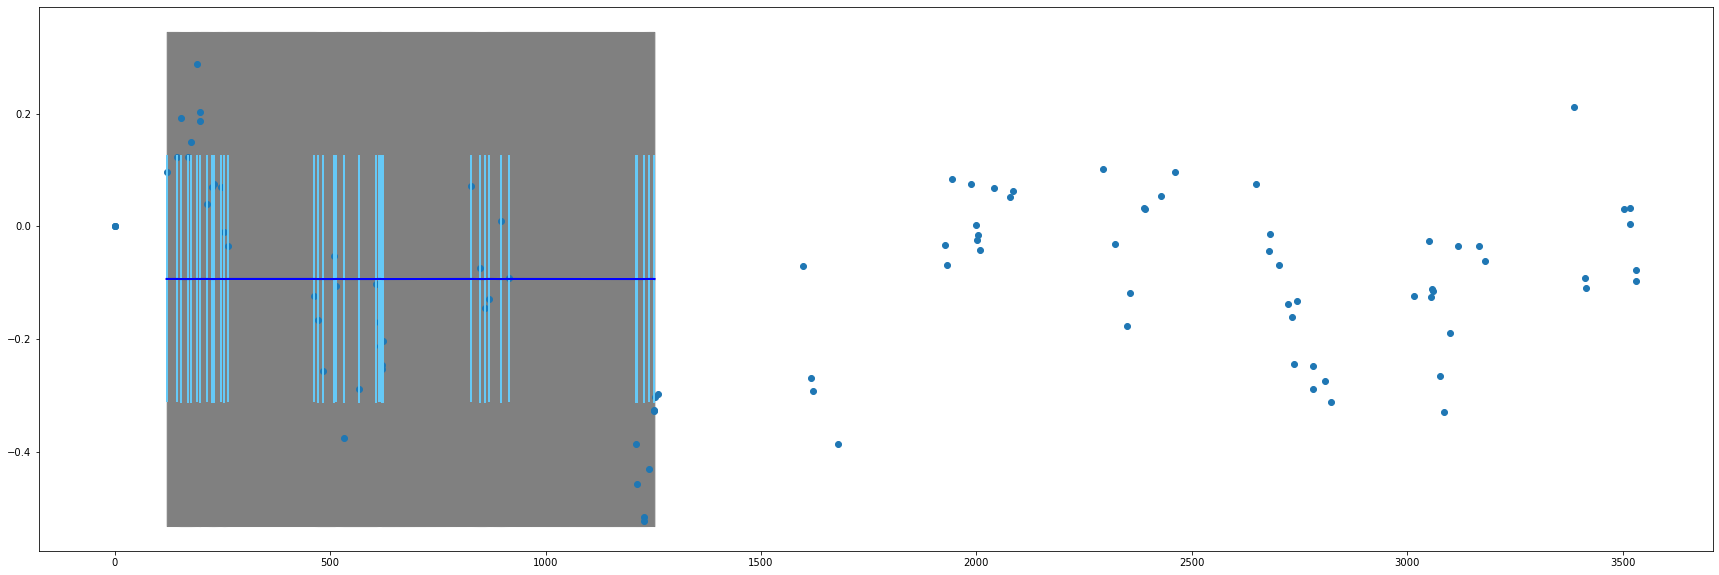

ValueError: too many values to unpack (expected 3)

In [48]:
# visualisation for one light curve w/ increasing number of points
def viz_per_example(example, target_x, net, num_points=40, device="mps", k_iwae=10, frac=0.5): 
    example = example[np.newaxis, :,:]
    target_x = target_x[np.newaxis, :, np.newaxis]
    np.random.seed(0)
    with torch.no_grad(): 
        # if torch.is_tensor(example):
        #     example = example.cpu().numpy()
        example = torch.tensor(example)
        # make new masks relative to fraction of points we got to predict w/ 
        subsampled_mask, recon_mask = my_utils.make_masks(example, frac=frac)
        #example = np.concatenate((example, smask[:,:,np.newaxis], rmask[:,:,np.newaxis], target_x), axis=-1) # format the masks 
        example = torch.cat((example, torch.unsqueeze(subsampled_mask, 2), torch.unsqueeze(recon_mask, 2), torch.tensor(target_x)), axis=-1)

        #example = torch.tensor(example)
        example = example.to(device)
        
        subsampled_mask = example[:,:,3:4]
        context_y = torch.cat((example[:,:, 1:2] * subsampled_mask, subsampled_mask), -1)
        px, qz = net.get_reconstruction(example[:,:, 0], context_y, example[:,:,5], num_samples=k_iwae)

        qz_mean = (qz.mean.cpu().numpy())
        qz_std = (torch.exp(0.5 * qz.logvar).cpu().numpy())
        px_mean = px.mean.cpu().numpy()
        px_std = torch.exp(0.5 * px.logvar).cpu().numpy()
        example = example.cpu().numpy()

        px_mean = np.mean(px_mean, axis=0)[0,:num_points,0]
        px_std = np.mean(px_std, axis=0)[0,:num_points,0]
        target_x = target_x[0,:num_points,0]
        w=2.0
        plt.figure(figsize=(30, 10))
        plt.fill_between(target_x, px_mean - 2*px_std, px_mean+2*px_std, color='gray')

        plt.plot(target_x, px_mean, c='b', lw=w, label='Reconstructions', zorder=20)
        plt.scatter(example[0,:,0], example[0,:,1])
        plt.errorbar(target_x, px_mean ,yerr=px_std,  ecolor='#65c9f7', c='b', lw=w, label='Reconstructions')

        plt.show()
        reconstruction = np.concatenate((target_x[:,np.newaxis], px_mean[:,np.newaxis], px_std[:,np.newaxis]), axis=1)
        #print(f'qz shape: {qz_mean.shape}')
        #print(f'reconstructed example: {reconstruction.shape}')
        return reconstruction, qz_mean,qz_std, example

_,_,_ = viz_per_example(samples[0,0,:,:], samples[0,0,:,0], net, num_points=40, device="mps", k_iwae=10, frac=0.5)

In [46]:
# really should make the dataset classs compatible with multivariate data
# same with visualization 
# approrpiate training schedule from transformer?
# try new encoder layers, after you've written them, intensity=False
# get rid of sampling the output?

(100, 1, 99, 6)

In [ ]:
# this stuff should all work, but kernel crashes with more than 1 dimension